# Medical Image Classification Tutorial with the MedNIST Dataset

In [1]:
!python -c "import monai" || pip install -q "monai-weekly[pillow, tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

In [2]:
import os
import shutil
import tempfile
import matplotlib.pyplot as plt
import PIL
import torch
import numpy as np
from sklearn.metrics import classification_report

from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import decollate_batch, DataLoader
from monai.metrics import ROCAUCMetric
from monai.networks.nets import DenseNet121
from monai.transforms import (
    Activations,
    EnsureChannelFirst,
    AsDiscrete,
    Compose,
    LoadImage,
    RandFlip,
    RandRotate,
    RandZoom,
    ScaleIntensity,
)
from monai.utils import set_determinism

print_config()

MONAI version: 1.2.0
Numpy version: 1.23.5
Pytorch version: 2.0.0
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: c33f1ba588ee00229a309000e888f9817b4f1934
MONAI __file__: /home/minyoungxi/anaconda3/envs/TorchEnv/lib/python3.8/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.1.0
scikit-image version: 0.21.0
Pillow version: 8.4.0
Tensorboard version: 2.13.0
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.15.0
tqdm version: 4.65.0
lmdb version: 1.4.1
psutil version: 5.9.0
pandas version: 2.0.3
einops version: 0.6.1
transformers version: 4.30.2
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-depend

MONAI_DATA_DIRECTORY 환경 변수로 디렉토리를 지정할 수 있습니다. 

이를 통해 결과를 저장하고 다운로드를 재사용할 수 있습니다. 지정하지 않으면 임시 디렉토리가 사용됩니다.

In [3]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")

root_dir = tempfile.mkdtemp() if directory is None else directory

print(root_dir)

/tmp/tmpzmbyrln4


Download dataset : MedNist 데이터

In [4]:
resource = "https://github.com/Project-MONAI/MONAI-extra-test-data/releases/download/0.8.1/MedNIST.tar.gz"
md5 = "0bc7306e7427e00ad1c5526a6677552d"

compressed_file = os.path.join(root_dir, "MedNIST.tar.gz")
data_dir = os.path.join(root_dir, "MedNIST")

if not os.path.exists(data_dir):
    download_and_extract(resource, compressed_file, root_dir, md5)

MedNIST.tar.gz: 59.0MB [00:03, 19.7MB/s]                                                                                                                                                                           

2023-08-14 22:10:31,537 - INFO - Downloaded: /tmp/tmpzmbyrln4/MedNIST.tar.gz
2023-08-14 22:10:31,615 - INFO - Verified 'MedNIST.tar.gz', md5: 0bc7306e7427e00ad1c5526a6677552d.
2023-08-14 22:10:31,615 - INFO - Writing into directory: /tmp/tmpzmbyrln4.


## Set deterministic training for reproducibility

* "Set deterministic training for reproducibility"는 모델 학습과 관련된 결과를 동일한 조건에서 반복해서 재현할 수 있도록 설정하는 것을 의미합니다. 딥러닝에서의 학습은 많은 무작위 연산이 포함되어 있기 때문에, 같은 데이터와 모델 구조를 사용하더라도 여러 번 학습을 진행하면 결과가 다를 수 있습니다. 이러한 무작위성은 초기 가중치 설정, 드롭아웃, 배치 정규화 등에서 발생합니다.

In [5]:
set_determinism(seed=0)

## Read image filenames from the dataset folders

먼저 데이터 세트 파일을 확인하고 일부 통계를 표시합니다.
데이터 세트에는 Hand, AbdomenCT, CXR, ChestCT, BreastMRI, HeadCT,
분류 모델을 훈련하기 위한 레이블로 사용해야 합니다.

In [6]:
class_names = sorted(x for x in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, x)))
num_class = len(class_names)
image_files = [
    [os.path.join(data_dir, class_names[i], x) for x in os.listdir(os.path.join(data_dir, class_names[i]))]
    for i in range(num_class)
]

num_each = [len(image_files[i]) for i in range(num_class)]
image_files_list = []
image_class = []

for i in range(num_class):
    image_files_list.extend(image_files[i])
    image_class.extend([i] * num_each[i])
num_total = len(image_class)

image_width, image_height = PIL.Image.open(image_files_list[0]).size

print(f"Total image count: {num_total}")
print(f"Image dimensions: {image_width} x {image_height}")
print(f"Label names: {class_names}")
print(f"Label counts: {num_each}")

Total image count: 58954
Image dimensions: 64 x 64
Label names: ['AbdomenCT', 'BreastMRI', 'CXR', 'ChestCT', 'Hand', 'HeadCT']
Label counts: [10000, 8954, 10000, 10000, 10000, 10000]


# Randomly pick images from dataset to visualize and check

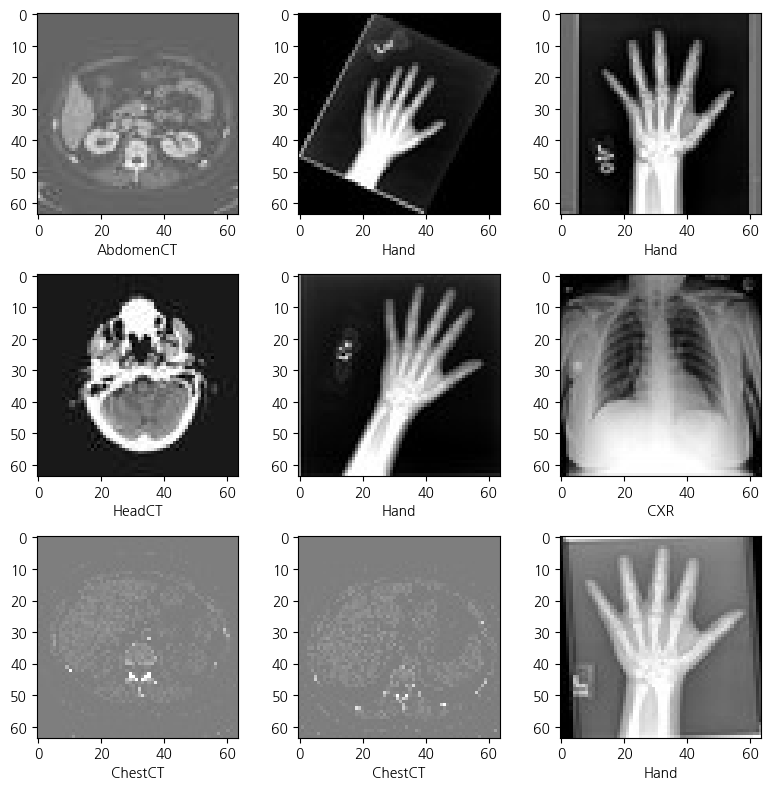

In [7]:
plt.subplots(3, 3, figsize=(8, 8))
for i, k in enumerate(np.random.randint(num_total, size=9)):
    im = PIL.Image.open(image_files_list[k])
    arr = np.array(im)
    plt.subplot(3, 3, i + 1)
    plt.xlabel(class_names[image_class[k]])
    plt.imshow(arr, cmap="gray", vmin=0, vmax=255)
plt.tight_layout()
plt.show()

# Preparing training, validation and test data lists

In [8]:
val_frac = 0.1  # 검증 및 테스트 데이터셋의 비율 (10% 설정)
test_frac = 0.1
length = len(image_files_list) # 전체 이미지 개수
indices = np.arange(length) # 0부터 전체이미지 개수-1까지의 정수 배열 생성
np.random.shuffle(indices) # 배열을 무작위로 섞기 

test_split = int(test_frac * length)
val_split = int(val_frac * length) + test_split

test_indices = indices[:test_split]
val_indices = indices[test_split:val_split]
train_indices = indices[val_split:]

train_x = [image_files_list[i] for i in train_indices]
train_y = [image_class[i] for i in train_indices]
val_x = [image_files_list[i] for i in val_indices]
val_y = [image_class[i] for i in val_indices]
test_x = [image_files_list[i] for i in test_indices]
test_y = [image_class[i] for i in test_indices]

print(f"Training count: {len(train_x)}, Validation count: " f"{len(val_x)}, Test count: {len(test_x)}")

Training count: 47164, Validation count: 5895, Test count: 5895


# Define MONAI transforms, Dataset and DataLoader to pre-process data

In [9]:
# MONAI의 Transforms 정의

train_transforms = Compose([       # Compose 함수: 이미지 전처리 및 변환을 위한 파이프라인을 정의할 때 사용. 
    LoadImage(image_only=True), # LoadImage()를 통해 이미지를 로드합니다. image_only=True옵션을 통해 이미지 데이터만 반환합니다.
    EnsureChannelFirst(), # 이미지 데이터의 채널을 첫 번째 차원으로 이동합니다. HxWxC -> CxHxW
    ScaleIntensity(), # 이미지의 픽셀 강도를 조절합니다. 
    RandRotate(range_x=np.pi/12, prob=0.5, keep_size=True), # 50%확률로 이미지를 최대 파이/12(약15도)만큼 회전, keep size=True는 회전 후에도 원래 이미지의 크기를 유지하라는 의미
    RandFlip(spatial_axis=0, prob=0.5), # 50%의 확률로 이미지를 첫 번째 공간 축을 기준으로 뒤집습니다.
    RandZoom(min_zoom=0.9, max_zoom=1.1, prob=0.5) # 50%의 확률로 이미지를 0.9배에서 1.1배 사이의 비율로 확대 및 축소합니다.
    ]
)

val_transforms = Compose([LoadImage(image_only=True), EnsureChannelFirst(), ScaleIntensity()])
# LoadImage(image_only=True): 이미지를 로드합니다.
# EnsureChannelFirst(): 이미지 데이터의 채널을 첫 번째 차원으로 이동시킵니다.
# ScaleIntensity(): 이미지의 픽셀 강도를 조정합니다.

y_pred_trans = Compose([Activations(softmax=True)]) # softmax 활성화 함수를 통해 예측값을 확률로 변환 

y_trans = Compose([AsDiscrete(to_onehot=num_class)]) # 예측값을 이산값으로 변환하며, 'to_oneshot'을 통해 클래스의 수에 따라 원-핫 인코딩을 적용합니다.

In [10]:
class MedNISTDataset(torch.utils.data.Dataset):
    def __init__(self, image_files, labels, transforms):
        self.image_files = image_files
        self.labels = labels
        self.transforms = transforms
        
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, index):
        return self.transforms(self.image_files[index]), self.labels[index]
    

train_ds = MedNISTDataset(train_x, train_y, train_transforms)
train_loader = DataLoader(train_ds, batch_size=300, shuffle=True, num_workers=10)

val_ds = MedNISTDataset(val_x, val_y, val_transforms)
val_loader = DataLoader(val_ds, batch_size=300, num_workers=10)

test_ds = MedNISTDataset(test_x, test_y, val_transforms)
test_loader = DataLoader(test_ds, batch_size=300, num_workers=10)

## Define network and optimizer

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DenseNet121(spatial_dims=2, in_channels=1, out_channels=num_class).to(device)
# spatial_dims=2: 이미지가 2차원임을 나타냅니다.

loss_function = torch.nn.CrossEntropyLoss()
# 다중 분류 문제에서 사용되는 교차 엔트로피 손실 함수입니다.

optimizer = torch.optim.Adam(model.parameters(), 1e-5)
# Adam 최적화 알고리즘을 사용하여 모델의 파라미터를 최적화합니다. 

max_epochs = 4
val_interval = 1 # 각 epoch 후에 검증을 수행할 간격을 설정합니다. 여기서는 매 epoch 후에 검증을 수행하도록 설정되었습니다.

auc_metric = ROCAUCMetric()
# ROC AUC (Receiver Operating Characteristic Area Under the Curve) 지표를 사용하여 모델의 성능을 평가합니다. ROC AUC는 이진 분류 또는 다중 레이블 분류에서 모델의 성능을 평가하는 데 널리 사용되는 지표입니다.

/home/minyoungxi/anaconda3/envs/TorchEnv/lib/python3.8/site-packages/torch/cuda/__init__.py:107: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /opt/conda/conda-bld/pytorch_1678402421473/work/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


# Model training

In [13]:
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader: # train_loader에서 배치 데이터를 순차적으로 가져옵니다. 
        step += 1
        inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"{step}/{len(train_ds) // train_loader.batch_size}, " f"train_loss: {loss.item():.4f}")
        epoch_len = len(train_ds) // train_loader.batch_size
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for val_data in val_loader:
                val_images, val_labels = (
                    val_data[0].to(device),
                    val_data[1].to(device),
                )
                y_pred = torch.cat([y_pred, model(val_images)], dim=0)
                y = torch.cat([y, val_labels], dim=0)
            y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
            y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
            auc_metric(y_pred_act, y_onehot)
            result = auc_metric.aggregate()
            auc_metric.reset()
            del y_pred_act, y_onehot
            metric_values.append(result)
            acc_value = torch.eq(y_pred.argmax(dim=1), y)
            acc_metric = acc_value.sum().item() / len(acc_value)
            if result > best_metric:
                best_metric = result
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current AUC: {result:.4f}"
                f" current accuracy: {acc_metric:.4f}"
                f" best AUC: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )

print(f"train completed, best_metric: {best_metric:.4f} " f"at epoch: {best_metric_epoch}")

----------
epoch 1/4
1/157, train_loss: 1.7943
2/157, train_loss: 1.7542
3/157, train_loss: 1.7552
4/157, train_loss: 1.7233
5/157, train_loss: 1.6867
6/157, train_loss: 1.6453
7/157, train_loss: 1.6251
8/157, train_loss: 1.5952
9/157, train_loss: 1.5842
10/157, train_loss: 1.5573
11/157, train_loss: 1.5183
12/157, train_loss: 1.5008
13/157, train_loss: 1.4523
14/157, train_loss: 1.4499
15/157, train_loss: 1.4345
16/157, train_loss: 1.4259
17/157, train_loss: 1.4103
18/157, train_loss: 1.3495
19/157, train_loss: 1.3588
20/157, train_loss: 1.3426
21/157, train_loss: 1.3104
22/157, train_loss: 1.2876
23/157, train_loss: 1.2775
24/157, train_loss: 1.2751
25/157, train_loss: 1.2483
26/157, train_loss: 1.2381
27/157, train_loss: 1.2057
28/157, train_loss: 1.2015
29/157, train_loss: 1.1679
30/157, train_loss: 1.1364
31/157, train_loss: 1.1289
32/157, train_loss: 1.1383
33/157, train_loss: 1.1146
34/157, train_loss: 1.1024
35/157, train_loss: 1.1043
36/157, train_loss: 1.0567
37/157, train_lo

137/157, train_loss: 0.0854
138/157, train_loss: 0.1275
139/157, train_loss: 0.0865
140/157, train_loss: 0.0811
141/157, train_loss: 0.0998
142/157, train_loss: 0.1053
143/157, train_loss: 0.0919
144/157, train_loss: 0.0959
145/157, train_loss: 0.0999
146/157, train_loss: 0.1093
147/157, train_loss: 0.0947
148/157, train_loss: 0.0888
149/157, train_loss: 0.0913
150/157, train_loss: 0.1093
151/157, train_loss: 0.1168
152/157, train_loss: 0.0911
153/157, train_loss: 0.1004
154/157, train_loss: 0.1015
155/157, train_loss: 0.0829
156/157, train_loss: 0.0952
157/157, train_loss: 0.0986
158/157, train_loss: 0.0746
epoch 2 average loss: 0.1456
saved new best metric model
current epoch: 2 current AUC: 0.9998 current accuracy: 0.9883 best AUC: 0.9998 at epoch: 2
----------
epoch 3/4
1/157, train_loss: 0.0851
2/157, train_loss: 0.0767
3/157, train_loss: 0.1196
4/157, train_loss: 0.0803
5/157, train_loss: 0.0800
6/157, train_loss: 0.0754
7/157, train_loss: 0.0891
8/157, train_loss: 0.0663
9/157, 

110/157, train_loss: 0.0349
111/157, train_loss: 0.0514
112/157, train_loss: 0.0629
113/157, train_loss: 0.0294
114/157, train_loss: 0.0228
115/157, train_loss: 0.0390
116/157, train_loss: 0.0314
117/157, train_loss: 0.0383
118/157, train_loss: 0.0307
119/157, train_loss: 0.0343
120/157, train_loss: 0.0243
121/157, train_loss: 0.0338
122/157, train_loss: 0.0370
123/157, train_loss: 0.0364
124/157, train_loss: 0.0286
125/157, train_loss: 0.0198
126/157, train_loss: 0.0551
127/157, train_loss: 0.0389
128/157, train_loss: 0.0296
129/157, train_loss: 0.0325
130/157, train_loss: 0.0429
131/157, train_loss: 0.0319
132/157, train_loss: 0.0299
133/157, train_loss: 0.0262
134/157, train_loss: 0.0334
135/157, train_loss: 0.0266
136/157, train_loss: 0.0263
137/157, train_loss: 0.0255
138/157, train_loss: 0.0366
139/157, train_loss: 0.0399
140/157, train_loss: 0.0377
141/157, train_loss: 0.0317
142/157, train_loss: 0.0366
143/157, train_loss: 0.0317
144/157, train_loss: 0.0255
145/157, train_loss:

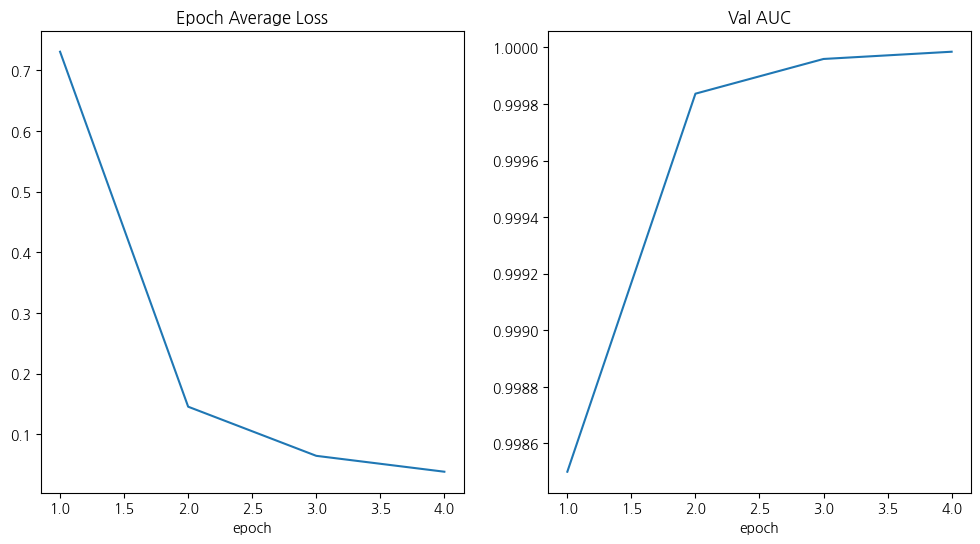

In [14]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val AUC")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

# Evaluate the model on test dataset

### state_dict 사용법

PyTorch에서 torch.nn.Module 모델의 학습 가능한 매개변수(예. 가중치와 편향)들은 모델의 매개변수에 포함되어 있습니다(model.parameters()로 접근합니다). state_dict 는 간단히 말해 각 계층을 매개변수 텐서로 매핑되는 Python 사전(dict) 객체입니다. 이 때, 학습 가능한 매개변수를 갖는 계층(합성곱 계층, 선형 계층 등) 및 등록된 버퍼들(batchnorm의 running_mean)만이 모델의 state_dict 에 항목을 가짐을 유의하시기 바랍니다. 옵티마이저 객체(torch.optim) 또한 옵티마이저의 상태 뿐만 아니라 사용된 하이퍼 매개변수(Hyperparameter) 정보가 포함된 state_dict 를 갖습니다.

state_dict 객체는 Python 사전이기 때문에 쉽게 저장하거나 갱신하거나 바꾸거나 되살릴 수 있으며, PyTorch 모델과 옵티마이저에 엄청난 모듈성(modularity)을 제공합니다.

In [15]:
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
# state_dict : 
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = (
            test_data[0].to(device),
            test_data[1].to(device),
        )
        pred = model(test_images).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

In [17]:
y_pred

[0,
 4,
 2,
 4,
 2,
 2,
 0,
 5,
 3,
 2,
 4,
 3,
 0,
 4,
 1,
 4,
 2,
 3,
 0,
 0,
 3,
 3,
 3,
 2,
 0,
 0,
 3,
 3,
 0,
 2,
 3,
 2,
 0,
 1,
 3,
 5,
 1,
 1,
 2,
 2,
 4,
 0,
 3,
 4,
 3,
 2,
 1,
 0,
 4,
 3,
 5,
 4,
 1,
 5,
 4,
 2,
 1,
 2,
 1,
 4,
 3,
 0,
 2,
 1,
 3,
 1,
 1,
 5,
 3,
 5,
 3,
 4,
 0,
 4,
 4,
 0,
 5,
 0,
 4,
 1,
 0,
 1,
 5,
 2,
 3,
 1,
 3,
 4,
 3,
 3,
 0,
 4,
 3,
 3,
 2,
 1,
 0,
 0,
 1,
 3,
 5,
 4,
 5,
 2,
 2,
 5,
 4,
 4,
 4,
 4,
 2,
 3,
 4,
 2,
 2,
 3,
 0,
 3,
 3,
 4,
 0,
 0,
 0,
 2,
 1,
 5,
 5,
 4,
 4,
 2,
 4,
 0,
 2,
 0,
 5,
 0,
 5,
 0,
 2,
 4,
 4,
 5,
 5,
 4,
 1,
 2,
 4,
 3,
 2,
 5,
 2,
 5,
 3,
 5,
 0,
 1,
 0,
 4,
 4,
 2,
 5,
 0,
 4,
 1,
 5,
 2,
 4,
 0,
 1,
 2,
 0,
 0,
 1,
 5,
 4,
 2,
 5,
 1,
 0,
 5,
 0,
 2,
 3,
 3,
 1,
 5,
 2,
 1,
 5,
 4,
 3,
 0,
 4,
 5,
 1,
 0,
 5,
 2,
 2,
 1,
 3,
 4,
 4,
 1,
 1,
 1,
 4,
 0,
 0,
 5,
 5,
 1,
 5,
 4,
 5,
 3,
 2,
 4,
 1,
 3,
 4,
 4,
 1,
 1,
 4,
 1,
 1,
 2,
 4,
 4,
 3,
 1,
 5,
 3,
 0,
 3,
 3,
 1,
 5,
 2,
 1,
 2,
 4,
 1,
 3,
 2,
 3,
 2,
 4,
 1,
